### Banking Discipline and Elasticity
J M Applegate.
##### CAS543 Complexity Economics
The notebook presents basic banking discipline and elasticity dynamics.  
A set of $n$ of retail customers are served by $N$ banks.  
Banks hold reserves as a central bank according to a specified reserve requirement.  
Customer transactions take place every day, and every night the reserve accounts need to be non-negative.  
Surplus banks lend to deficit banks as requested to meet the overnight non-negative reserve requirement.  

In [19]:
# import packages
from ipywidgets import widgets
from IPython.display import display, clear_output, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import seaborn as sns
import random
rng = np.random.default_rng()

In [20]:
# set parameters
n = 1000 # number of retail customers
N = 10 # number of banks
steps = 888 # number of simulation runs
tau = 200 # parameter for poisson function, mean number of transactions a step
reserve_reqmt = .5 # percentage of initial retail deposits as reserves
cb_rate = .02 # central bank lending rate
bailouts_are_allowed = True
backstop_rate = .25 # central bank backstop rate
bailout_deficit_multiplier = 1.1 # multiplier on current deficit to calculate bailout amount. this is not ideal but we lack global state
premium_basis = .01 # basis for risk premium
broker_network_fraction = 1 # TODO isnʻt working as intended. fraction of banks that can be "reached" by a broker 
max_balance = 100 # upper limit for initial retail deposits
do_display = False

Updates: We have added a risk assessment and pricing component to the intrabank lending model. `update_net_positions` updates a risk assessment factor for each bank based on how they are positioned with respect to their reserve requirements. `get_lender_quote` is called for every lender to obtain a priced proposition for a loan to the bank in question based on the risk assessment. 

In [21]:
# define utility functions

# a serious utility
def maybe_display(message, do_display):
    if do_display:
        display(message)


# New!
def get_lender_quote(lender, borrower, reserves, net_positions, risk_appetites, cb_rate):
    # get_lender_quote simulates a agent shopping for quotes for overnight loans
    # thus giving us a pricing mechanism based on risk preference

    risk_premium = max(premium_basis, -net_positions[borrower]) * premium_basis # always charge at least cb_rate + premium_basis
    
    # factor in the lender's risk appetite
    adjusted_premium = risk_premium * (1 - risk_appetites[lender])

    # calculate with an arbitrary upper bound of 3x the cb_rate
    quote = min(cb_rate + adjusted_premium, 3 * cb_rate)

    # maybe_display(f"Lender {lender} has a risk appetite of {risk_appetites[lender]}")
    # maybe_display(f"Borrower {borrower} has a net position of {net_positions[borrower]}")
    # maybe_display(f"The adjusted premium for lender {lender} is {adjusted_premium}")
    # maybe_display(f"The quote for lender {lender} is {quote}")

    return (quote, True)

# New!
def calculate_avg_overnight_rate(loans, rates):
    total_weighted_cost = 0
    total_loan_volume = 0
    
    # Sum up (loan * rate) for all loans
    for bank_loans, bank_rates in zip(loans, rates):
        for loan, rate in zip(bank_loans, bank_rates):
            total_weighted_cost += loan * rate
            total_loan_volume += loan
    
    # Calculate weighted average, return 0 if no loans
    if total_loan_volume > 0:
        return total_weighted_cost / total_loan_volume
    return 0

# define model functions

# New!
def update_net_positions(N, loans, rates, reserves, customers, banks, balances):
    # For all of our banks, we want to calculate how well they are keeping up with the reserve requirement
    # This is sort of a proxy for bank health in light of the fact that
    # loans in the model are simulated rather than operational.
    # Note that this could also be calculated on the spot from reserves and loans, but
    # that would be a pain in the neck. Also, maybe we would want to get more clever about
    # bank health in the future.
    
    # Initialize net positions list
    net_positions = []
    
    # Calculate required reserves for each bank
    for B in range(N):
        # Calculate total deposits for this bank
        bank_deposits = 0
        for c in range(len(customers)):
            if banks[c] == B:
                bank_deposits += balances[c]
                
        required_reserves = bank_deposits * reserve_reqmt
        
        # Calculate loan costs
        loan_principal = sum(loans[B])
        
        # Calculate interest costs
        interest_cost = 0
        for loan, rate in zip(loans[B], rates[B]):
            interest_cost += loan * rate
        
         # Calculate net position as a ratio to required reserves
        if required_reserves > 0:  # Avoid division by zero
            net_position = (reserves[B] - loan_principal - interest_cost - required_reserves) / required_reserves
        else:
            net_position = 0 # TODO not sure about conditions with no required reserves
        
        net_positions.append(net_position)
    return net_positions

# Existing!
# create reserves from retail deposit amounts
def create_reserves(N, customers, banks, balances, reserve_reqmt):
    deposits = []
    for B in range(N):
        bank_deposits = 0
        for c in customers:
            if banks[c] == B:
                bank_deposits += balances[c]
        deposits.append(bank_deposits)
    reserves = [reserve_reqmt * d for d in deposits]
    return(reserves)

# retail customers conduct transactions which are settled through aggregated central bank reserve transfers
def retail_transactions(tau, customers, banks, balances, reserves):
    transfers = rng.poisson(tau)
    originators = random.choices(customers, weights = balances, k=transfers) # originators weighted on bank balances
    #originators = random.choices(customers, k=transfers) #unwe
    percentages = rng.random(transfers).tolist()
    recipients = []
    for o in originators:
        others = [c for c in customers if c != o]
        other_balances = [b for i, b in enumerate(balances) if i != o] 
        recipient = random.choices(others, weights = other_balances)[0] # recipients weighted on bank balances
        #recipient = random.choices(others)[0]
        recipients.append(recipient)
    originating_banks = [banks[o] for o in originators]
    receiving_banks = [banks[r] for r in recipients]
    for t in range(transfers):
        amount = percentages[t] * balances[originators[t]]
        balances[recipients[t]] += amount
        balances[originators[t]] -= amount
        reserves[receiving_banks[t]] += amount
        reserves[originating_banks[t]] -= amount
    return(balances, reserves)

# surplus banks lend to deficit banks at the end of the day to ensure all reserve accounts are non-negative
def settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites):
    # in the unlikely event of a bailout...
    bailouts = []

    deficit_banks = [i for i, b in enumerate(reserves) if b < 0]
    possible_lenders = [x for x in range(N) if x not in deficit_banks]
    # Fed borrowers cannot offer quotes, so remove any possible lender with a loan from None
    possible_lenders = [x for x in possible_lenders if lenders[x] is not None]
    random.shuffle(possible_lenders)

    # in order to settle deficits, we need to get quotes from lenders
    # we simulate using a broker with "limited reach" to other banks
    # the broker will then choose the lowest quote and lend to the borrower

    broker_reach = int(N * broker_network_fraction)

    for i in deficit_banks:
        if len(possible_lenders) >= broker_reach:
            selected_lenders = random.sample(possible_lenders, broker_reach)
        else:
            selected_lenders = possible_lenders
            
        # Get quotes from each selected lender
        quotes = []
        for lender in selected_lenders:            
            quote, can_lend = get_lender_quote(
                lender, i, reserves, net_positions, 
                risk_appetites, cb_rate
            )
            if can_lend:
                quotes.append((lender, quote))
    
        # order the quotes by the quote amount
        if quotes:
            lowest_quotes_first = sorted(quotes, key=lambda x: x[1])
            j = 0
            while reserves[i] < 0 and j < len(lowest_quotes_first):
                lender = lowest_quotes_first[j][0]
                quoted_rate = lowest_quotes_first[j][1]
                if reserves[lender] >= abs(reserves[i]):
                    reserves[lender] += reserves[i]
                    maybe_display(f"Writing full loan to borrower {i} from lender {lender} for amount {abs(reserves[i])} at rate {quoted_rate}", do_display)
                    loans[i].append(abs(reserves[i]))
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] = 0
                    maybe_display(f"Lender {lender} has {reserves[lender]} reserves remaining. Borrower {i} has {reserves[i]} reserves remaining.", do_display)
                elif reserves[lender] > 0:
                    maybe_display(f"Writing partial loan to borrower {i} from lender {lender} for amount {reserves[lender]} at rate {quoted_rate}", do_display)
                    loans[i].append(reserves[lender])
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] += reserves[lender]
                    reserves[lender] = 0
                    maybe_display(f"Lender {lender} has {reserves[lender]} reserves remaining. Borrower {i} has {reserves[i]} reserves remaining.", do_display)                    
                    j += 1
                else:
                    maybe_display(f"Lender {lender} has no reserves to lend", do_display)
                    j += 1
        
    for i_bad in deficit_banks:
        # if we still have a deficit, we need to call the Fed
        # Fed will repay all the outstanding loans and then set the bankʻs reserves back to the recap amount
        # This will go onto the books as one loan from the fed, at the backstop rate
        # And then we will set the risk appetite to 0.01

        if reserves[i_bad] < 0:  # Removed bailouts_are_allowed check since we always need to resolve negatives
            display(f"Borrower {i_bad} needs a bailout")
            display(f"Borrower {i_bad} has {reserves[i_bad]} reserves")
            display(f"Borrower {i_bad} has {loans[i_bad]} loans")

            # First, repay all existing loans
            for idx, loan in enumerate(loans[i_bad]):
                lender = lenders[i_bad][idx]
                rate = rates[i_bad][idx]
                if lender is not None:  # if it's not already a Fed loan
                    reserves[lender] += loan * (1 + rate)  # Repay with interest

            # now reset the bank
            recap_amount = max_balance * bailout_deficit_multiplier
            display(f"Borrower {i_bad} needs a bailout of {recap_amount}")
            loans[i_bad] = [recap_amount] # REPLACE the loans, donʻt append. Fed ensures all outstanding debt is repaid.
            rates[i_bad] = [backstop_rate]
            lenders[i_bad] = [None]
            reserves[i_bad] = recap_amount
            risk_appetites[i_bad] = 0.01
            bailouts.append((i_bad, recap_amount))
            
            display(f"Fed bailout complete. Borrower {i_bad} now has {loans[i_bad]} loans and {reserves[i_bad]} reserves.")

    return(reserves, loans, rates, lenders, bailouts)

# borrowing banks repay overnight loans
def repay_loans(N, loans, rates, lenders, reserves):
    for B in range(N):
        for i, loan in enumerate(loans[B]):
            rate = rates[B][i] # stored right alongside the loans now, cb_rate baked in.
            lender = lenders[B][i]

            # if lender is  None, itʻs a fed loan
            if lender is not None: # normal interbank loan
                reserves[lender] += loan * (1 + rate)
            # but, still need to deduct from borrowing bank whether Fed or other bank
            reserves[B] -= loan * (1 + rate)

            loans[B].pop(0)
            rates[B].pop(0)
            lenders[B].pop(0)
    return(loans, rates, lenders, reserves)

In [22]:
# initialise data structures
customers = list(range(n))
banks = rng.choice(range(N), n).tolist()
balances = rng.uniform(1, max_balance, n).tolist()
loans = [[] for _ in range(N)]
rates = [[] for _ in range(N)]
lenders = [[] for _ in range(N)]
customer_history = pd.DataFrame()
bank_history = pd.DataFrame()
financial_system_history = pd.DataFrame()

# calculate reserves based on retail deposits
reserves = create_reserves(N, customers, banks, balances, reserve_reqmt)

# we should now be able to initialize our asset positions
net_positions = update_net_positions(N, loans, rates, reserves, customers, banks, balances)

# and our risk appetites are simple enough...
risk_appetites = rng.uniform(0, 0.5, N).tolist()

# populate history arrays with initial values
customer_history['step'] = [0] * n
customer_history['id'] = customers
customer_history['balance'] = balances
bank_history['step'] = [0] * N
bank_history['id'] = list(range(N))
bank_history['reserves'] = reserves
bank_history['loans'] = [sum(l0) for l0 in loans]
bank_history['rates'] = [[] for _ in range(N)]
bank_history['net_positions'] = net_positions
bank_history['risk_appetite'] = risk_appetites
# these are vectors but only one history for the whole system. so, no "N"
financial_system_history['step'] = [0]
financial_system_history['average_net_position'] = [0]
financial_system_history['avg_daily_rate'] = [0]
financial_system_history['average_risk_appetite'] = [0]
financial_system_history['fed_recapitalization'] = [None] # 0 to many banks can be taken over by the fed each step, store as list or None

for s in range(1, steps+1):

    maybe_display(f"Step {s}", do_display)
    
    #repay overnight loans
    loans, rates, lenders, reserves = repay_loans(N, loans, rates, lenders, reserves)
            
    #conduct retail customer activity
    balances, reserves = retail_transactions(tau, customers, banks, balances, reserves)

    #settle negative reserve accounts at end of day
    # note that we pass in the customers and banks in order to deal with bailout conditions
    reserves, loans, rates, lenders, bailouts = settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites)

    #and finally update our net_positions
    net_positions = update_net_positions(N, loans, rates, reserves, customers, banks, balances)

    # store simulation values as dataframes
    customer_step = pd.DataFrame()
    bank_step = pd.DataFrame()
    financial_system_step = pd.DataFrame()

    customer_step['step'] = [s] * n
    customer_step['id'] = customers
    customer_step['balance'] = balances

    bank_step['step'] = [s] * N
    bank_step['id'] = list(range(N))
    bank_step['reserves'] = reserves
    bank_step['loans'] = [sum(l1) for l1 in loans]

    financial_system_step['step'] = [s]
    financial_system_step['avg_daily_rate'] = [calculate_avg_overnight_rate(loans, rates)]
    financial_system_step['average_net_position'] = [sum(net_positions) / N]
    financial_system_step['average_risk_appetite'] = [sum(risk_appetites) / N]
    financial_system_step['fed_recapitalization'] = [bailouts]


    customer_history = pd.concat([customer_history, customer_step], ignore_index=True)
    bank_history = pd.concat([bank_history, bank_step], ignore_index=True)
    financial_system_history = pd.concat([financial_system_history, financial_system_step], ignore_index=True)

The first set of simulation result plots show  
1) retail deposit account balances for each customer over time
2) reserve account balances for each bank over time.

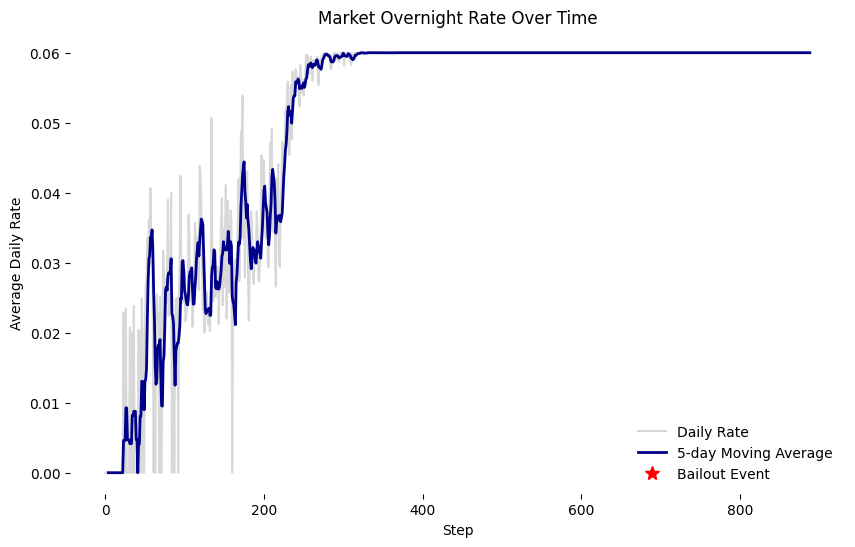

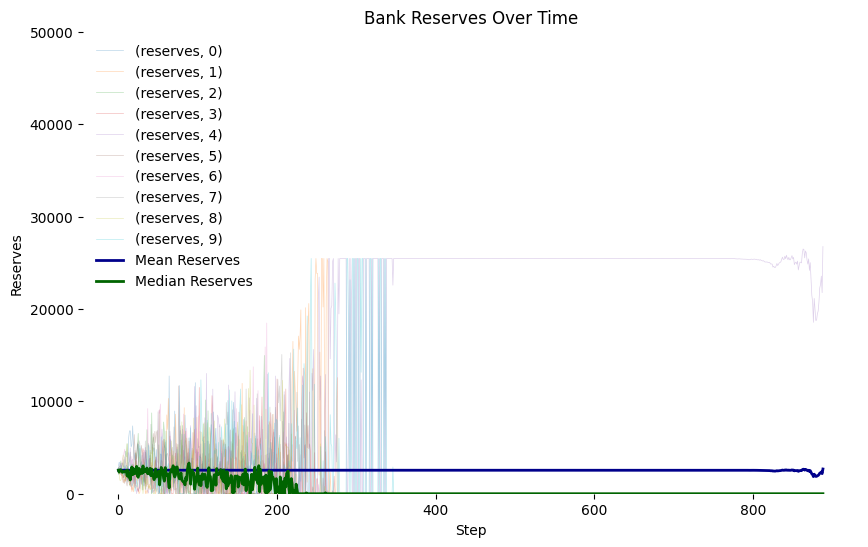

In [23]:
# For the market rate plot
plt.figure(figsize=(10, 6))
# Plot individual rates
plt.plot(financial_system_history['step'], financial_system_history['avg_daily_rate'], 
         alpha=0.3, color='gray', label='Daily Rate')
# Add rolling mean
rolling_mean = financial_system_history['avg_daily_rate'].rolling(window=5).mean()
plt.plot(financial_system_history['step'], rolling_mean, 
         color='darkblue', linewidth=2, label='5-day Moving Average')

# Add stars for bailout events
bailout_steps = financial_system_history[financial_system_history['fed_recapitalization'].apply(lambda x: x is not None and len(x) > 0)]['step']
bailout_rates = financial_system_history[financial_system_history['fed_recapitalization'].apply(lambda x: x is not None and len(x) > 0)]['avg_daily_rate']
plt.plot(bailout_steps, bailout_rates, '*', color='red', markersize=10, label='Bailout Event')

plt.title('Market Overnight Rate Over Time')
plt.xlabel('Step')
plt.ylabel('Average Daily Rate')
plt.legend(frameon=False)
sns.despine(left=True, bottom=True)
plt.show()

# For the reserves plot
plt.figure(figsize=(10, 6))
bank_wide = pd.pivot_table(bank_history, index=['step'], values=['reserves'], columns=['id'])

# Plot individual bank lines with low opacity
bank_wide.plot(linewidth=0.5, alpha=0.3, legend=None, ax=plt.gca())

# Add mean and median lines
plt.plot(bank_wide.index, bank_wide.mean(axis=1), 
         color='darkblue', linewidth=2, label='Mean Reserves')
plt.plot(bank_wide.index, bank_wide.median(axis=1), 
         color='darkgreen', linewidth=2, label='Median Reserves')

# Max the bank-wide plot y axis at 500 times the initial max value
plt.ylim(0, 500 * max_balance)

# Add stars for bailout events
for step in bailout_steps:
    plt.axvline(x=step, color='red', alpha=0.2, linestyle='--')
    plt.plot(step, bank_wide.loc[step].max(), '*', color='red', markersize=10)

plt.title('Bank Reserves Over Time')
plt.xlabel('Step')
plt.ylabel('Reserves')
plt.legend(frameon=False)
sns.despine(left=True, bottom=True)
plt.show()

These plots show the distribution of customer bank balances at the beginning of the simuation and the mean values at the end of the simulation steps.

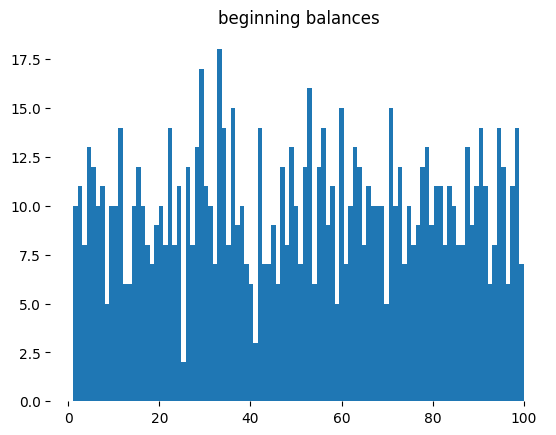

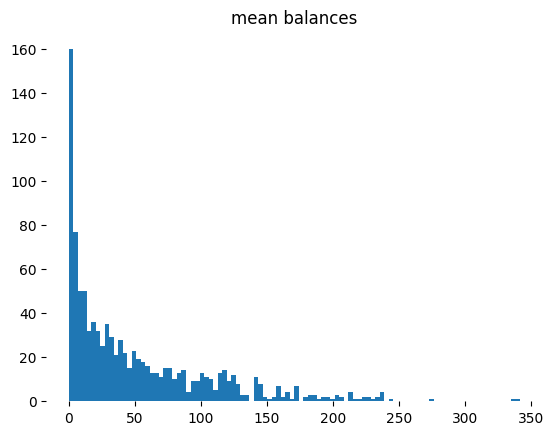

In [24]:
customer_history[customer_history['step'] == 0].hist('balance', bins = 100, grid=False)
plt.title('beginning balances')
sns.despine(left = True, bottom = True)
plt.show()

customer_history.groupby('id').mean().hist('balance', bins = 100, grid=False)
plt.title('mean balances')
sns.despine(left = True, bottom = True)

In [25]:
from IPython.display import display

display(financial_system_history)


,step,average_net_position,avg_daily_rate,average_risk_appetite,fed_recapitalization
0,0,0.000000e+00,0.00,0.000000,None
1,1,-3.587143e-03,0.00,0.218595,[]
2,2,-9.081133e-03,0.00,0.218595,[]
3,3,-8.755578e-03,0.00,0.218595,[]
4,4,-6.606846e-03,0.00,0.218595,[]
...,...,...,...,...,...
884,884,-1.005032e+15,0.06,0.218595,[]
885,885,-1.992583e+15,0.06,0.218595,[]
886,886,-9.966778e+14,0.06,0.218595,[]
887,887,-1.242026e+15,0.06,0.218595,[]


This final plot shows, for each bank, mean reserve and loan values.

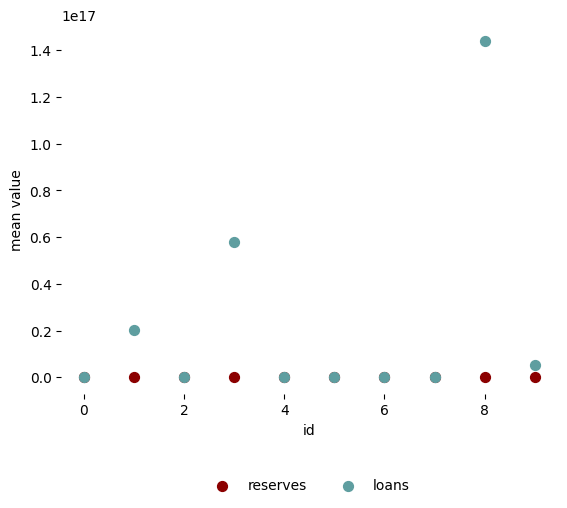

In [26]:
bank_means = bank_history[['id', 'reserves', 'loans']].groupby(by='id').mean()
bank_means = bank_means.reset_index()
ax = bank_means.plot.scatter(x = 'id', y = 'reserves', c = 'darkred', label = 'reserves', s = 50)
bank_means.plot.scatter(x = 'id', y = 'loans', c = 'cadetblue', label = 'loans', facecolors='none', s = 50, ax = ax)
plt.ylabel('mean value')
plt.legend(frameon=False, bbox_to_anchor=(0.5, -.3), loc='lower center', ncol=2)
sns.despine(left = True, bottom = True)

Letʻs see if we can discern what is happening with an animated plot

In [18]:
bank_history_output = widgets.Output()

def plot_bank_reserves_history():
    """Create an animated bar chart of bank reserves ordered by risk appetite"""
    with bank_history_output:
        clear_output(wait=True)
        plt.close('all')  # Close any existing figures
        
        # Create figure for animation
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Sort banks by risk appetite
        sorted_indices = sorted(range(len(risk_appetites)), key=lambda k: risk_appetites[k])
        sorted_appetites = [risk_appetites[i] for i in sorted_indices]
        
        # Calculate y-axis limits once
        all_reserves = [r for step_data in bank_history.groupby('step')['reserves'] for r in step_data[1]]
        y_min = min(all_reserves)
        y_max = min(50000, max(all_reserves))
        
        def update(frame):
            ax.clear()
            step_data = bank_history[bank_history['step'] == frame]
            
            # Get reserves for this step, sorted by risk appetite
            reserves = [step_data[step_data['id'] == i]['reserves'].values[0] for i in sorted_indices]
            
            # Create bar plot with color gradient
            colors = plt.cm.viridis(np.linspace(0, 1, len(reserves)))
            bars = ax.bar(range(len(reserves)), reserves, color=colors)
            
            # Set static y-axis limits
            ax.set_ylim(y_min, y_max)
            
            # Customize the plot
            ax.set_title(f'Bank Reserves by Risk Appetite (Step {frame})')
            ax.set_xlabel('Banks (ordered by risk appetite)')
            ax.set_ylabel('Reserves')
            
            # Set x-ticks to show risk appetites
            ax.set_xticks(range(len(sorted_appetites)))
            ax.set_xticklabels([f'{a:.2f}' for a in sorted_appetites], rotation=45)
            
            sns.despine(left=True, bottom=True)
            plt.tight_layout()
        
        # Create animation
        global bank_history_anim
        bank_history_anim = animation.FuncAnimation(
            fig,
            update,
            frames=bank_history['step'].unique(),
            interval=200,
            repeat=False
        )
        
        # Display the animation
        display(HTML(bank_history_anim.to_jshtml()))
        plt.close()



# autorun animation
display(bank_history_output)
plot_bank_reserves_history()




Output()